In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.init as init
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms,datasets


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:
class MNISTDataset(Dataset):
    def __init__(self, csv_file_path, transform=None):
        self.data = pd.read_csv(csv_file_path)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data.iloc[idx, 1:].values.astype('float32').reshape((28, 28, 1))
        image = (image / 127.5) - 1.0
        label = int(self.data.iloc[idx, 0])
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [7]:
csv_file_path = '/project/jacobcha/nk643/gans/data/fashion-mnist_train.csv'
transform = transforms.ToTensor()  # Convert images to PyTorch tensors

mnist_dataset = MNISTDataset(csv_file_path, transform=transform)

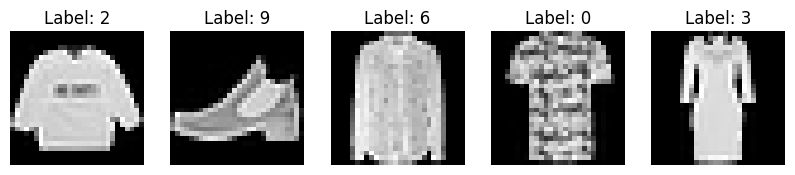

In [9]:
import matplotlib.pyplot as plt

def show_example_data(dataset, num_samples=5):
    plt.figure(figsize=(10, 2))
    
    for i in range(num_samples):
        image, label = dataset[i]
        image = image.numpy().squeeze()  # Convert to numpy array and remove channel dimension for plotting

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Label: {label}")
        plt.axis('off')

    plt.show()

# Assuming mnist_dataset is your MNISTDataset instance
show_example_data(mnist_dataset)


In [20]:
batch_size = 128
data_loader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True)

In [21]:
# Latent dimension of the random noise
LATENT_DIM = 100

# Number of channels, 1 for grayscale and 3 for color images
CHANNELS = 1  # Change to 3 if working with color images

# Size of the image
IMG_SIZE = 28

# Learning rate
LEARNING_RATE = 0.0002

# Beta1 hyperparam for Adam optimizers
BETA1 = 0.5

In [22]:
# Generator network
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(LATENT_DIM, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, CHANNELS * IMG_SIZE * IMG_SIZE),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), CHANNELS, IMG_SIZE, IMG_SIZE)
        return x

In [23]:
# Discriminator network
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(CHANNELS * IMG_SIZE * IMG_SIZE, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.model(x)

In [24]:
# Initialize networks
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [25]:
optimizer_G = optim.Adam(generator.parameters(), lr=LEARNING_RATE)
optimizer_D = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE)

In [26]:
class GAN(nn.Module):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def forward(self, real_images):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # Train Discriminator
        noise = torch.randn(batch_size, self.latent_dim).to(device)
        fake = self.generator(noise)
        labels_real = torch.ones(batch_size, 1).to(device)
        labels_fake = torch.zeros(batch_size, 1).to(device)

        outputs_real = self.discriminator(real_images)
        loss_real = self.loss_fn(outputs_real, labels_real)
        
        outputs_fake = self.discriminator(fake.detach())
        loss_fake = self.loss_fn(outputs_fake, labels_fake)
        
        loss_D = (loss_real + loss_fake) / 2
        self.d_optimizer.zero_grad()
        loss_D.backward()
        self.d_optimizer.step()

        # Train Generator
        outputs_fake = discriminator(fake)
        loss_G = self.loss_fn(outputs_fake, labels_real)
        
        self.g_optimizer.zero_grad()
        loss_G.backward()
        self.g_optimizer.step()

        return {"d_loss": loss_D.item(), "g_loss": loss_G.item()}

    def compute_metrics(self, real_images):
        batch_size = real_images.size(0)
        noise = torch.randn(batch_size, self.latent_dim, device=real_images.device)

        # Compute predictions
        pred_real = self.discriminator(real_images)
        fake_images = self.generator(noise)
        pred_fake = self.discriminator(fake_images)

        # Calculate accuracy metrics
        real_accuracy = torch.mean((pred_real > 0.5).float())
        fake_accuracy = torch.mean((pred_fake <= 0.5).float())

        return {"real_accuracy": real_accuracy.item(), "fake_accuracy": fake_accuracy.item()}

In [27]:
# Loss function
loss_fn = nn.BCELoss()

In [28]:
gan = GAN(discriminator, generator, LATENT_DIM)

# Compile the DCGAN model
gan.compile(optimizer_D, optimizer_G, loss_fn)

In [29]:
class GANMonitor:
    def __init__(self, num_img=3, latent_dim=100, output_dir='/project/jacobcha/nk643/gans/output/normal_gan'):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.output_dir = output_dir
        # Ensure the seed is on the same device as the generator
        self.seed =  torch.randn(batch_size, self.latent_dim).to(device)

    def on_epoch_end(self, epoch, generator):
        generator.eval()
        with torch.no_grad():
            # Generate images and move them to CPU for visualization
            generated_images = generator(self.seed).to('cpu')

            # Rescale images from [-1, 1] to [0, 255]
            generated_images = (generated_images * 127.5) + 127.5
            generated_images = generated_images.clamp(0, 255)
  
            # Plot and save images
            fig = plt.figure(figsize=(4, 4))
            for i in range(self.num_img):
                plt.subplot(4, 4, i + 1)
                plt.imshow(generated_images[i].squeeze(0), cmap='gray')
                plt.axis('off')
            plt.savefig(f'{self.output_dir}/epoch_{epoch:03d}.png')
            plt.show()

    def on_train_end(self, generator, discriminator):
        torch.save(generator.state_dict(), f'{self.output_dir}/generator.pth')
        torch.save(discriminator.state_dict(), f'{self.output_dir}/discriminator.pth')


Epoch [0/20] - D Loss: 0.249095, G Loss: 1.786620
Real Accuracy: 0.875000, Fake Accuracy: 0.989583


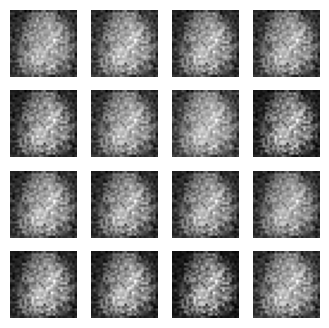

Epoch [1/20] - D Loss: 0.459519, G Loss: 1.669449
Real Accuracy: 0.770833, Fake Accuracy: 0.822917


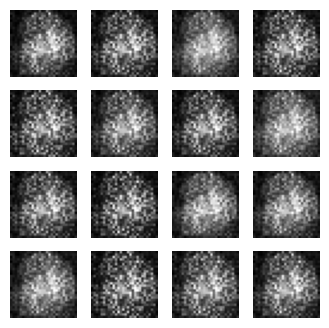

Epoch [2/20] - D Loss: 0.430601, G Loss: 2.111199
Real Accuracy: 0.802083, Fake Accuracy: 0.802083


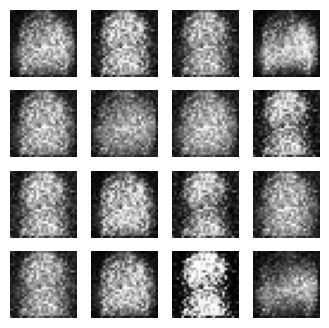

Epoch [3/20] - D Loss: 0.589424, G Loss: 1.460794
Real Accuracy: 0.708333, Fake Accuracy: 0.552083


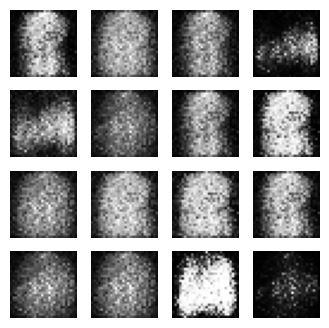

Epoch [4/20] - D Loss: 0.279089, G Loss: 2.436540
Real Accuracy: 0.947917, Fake Accuracy: 0.802083


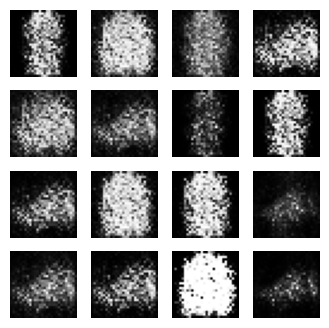

Epoch [5/20] - D Loss: 0.252039, G Loss: 3.533712
Real Accuracy: 0.864583, Fake Accuracy: 0.937500


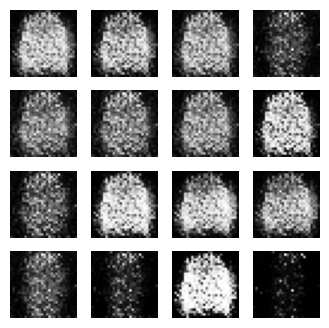

Epoch [6/20] - D Loss: 0.275832, G Loss: 5.316264
Real Accuracy: 0.875000, Fake Accuracy: 0.927083


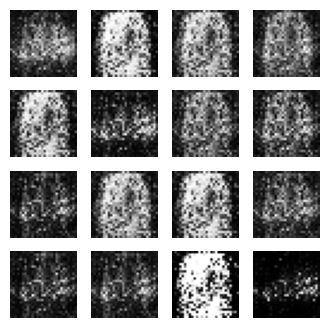

Epoch [7/20] - D Loss: 0.582128, G Loss: 3.132445
Real Accuracy: 0.864583, Fake Accuracy: 0.791667


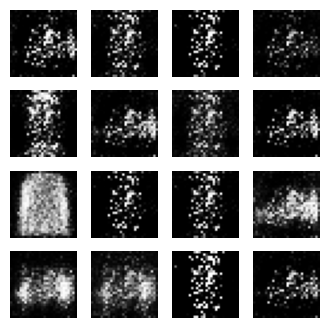

Epoch [8/20] - D Loss: 0.196654, G Loss: 3.347679
Real Accuracy: 0.927083, Fake Accuracy: 0.927083


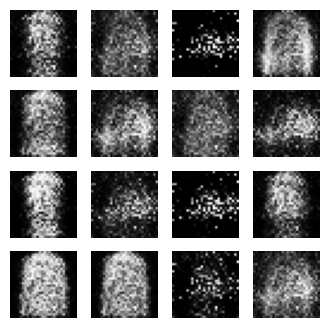

Epoch [9/20] - D Loss: 0.286465, G Loss: 3.032049
Real Accuracy: 0.812500, Fake Accuracy: 0.875000


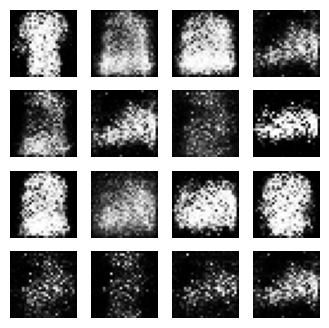

Epoch [10/20] - D Loss: 0.351160, G Loss: 2.628260
Real Accuracy: 0.812500, Fake Accuracy: 0.875000


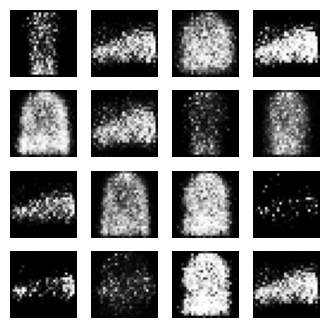

Epoch [11/20] - D Loss: 0.388810, G Loss: 2.294917
Real Accuracy: 0.802083, Fake Accuracy: 0.791667


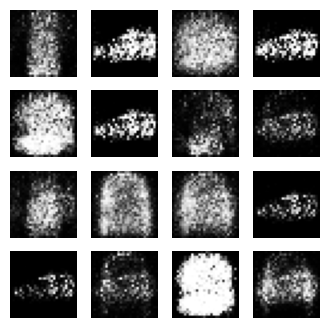

Epoch [12/20] - D Loss: 0.370004, G Loss: 2.912521
Real Accuracy: 0.812500, Fake Accuracy: 0.927083


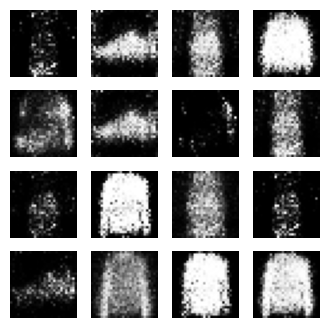

Epoch [13/20] - D Loss: 0.353497, G Loss: 2.745183
Real Accuracy: 0.770833, Fake Accuracy: 0.927083


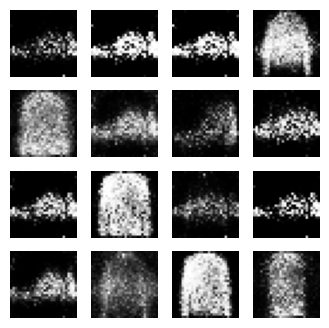

KeyboardInterrupt: 

In [30]:
NUM_EPOCHS = 20  # Number of epochs

# Create an instance of GANMonitor
monitor = GANMonitor(num_img=16, latent_dim=LATENT_DIM)

# Training loop
for epoch in range(NUM_EPOCHS):
    for batch_idx, (real_images, _) in enumerate(data_loader):  # Replace train_loader with your DataLoader
        real_images = real_images.to(device) # Move real_images to the appropriate device

        # Train the GAN model for one batch
        training_stats = gan(real_images)

    # Calculate and print the accuracy metrics for the current epoch
    metrics = gan.compute_metrics(real_images)
    print(f"Epoch [{epoch}/{NUM_EPOCHS}] - D Loss: {training_stats['d_loss']:.6f}, G Loss: {training_stats['g_loss']:.6f}")
    print(f"Real Accuracy: {metrics['real_accuracy']:.6f}, Fake Accuracy: {metrics['fake_accuracy']:.6f}")


    # Call the GANMonitor callback to visualize generated images at the end of each epoch
    monitor.on_epoch_end(epoch, generator)

# After training, save the generator model
monitor.on_train_end(generator, discriminator)